In [1]:
import pandas as pd
import numpy as np
import gurobipy as gp
import matplotlib.pyplot as plt

In [ ]:
prices_2019 = pd.read_csv('stocks2019.csv')
prices_2020 = pd.read_csv('stocks2020.csv')
returns = prices_2019.iloc[:,1:].pct_change().dropna()
returns_2020 = prices_2020.iloc[:,1:].pct_change().dropna()

cor = returns.iloc[:,1:].corr() #ignoring the date column
n = len(cor) #n stocks in the index

In [3]:
#Creating the constraint matrix, objective function and bvec for optimization
A = np.zeros((n*n+1+n,n*n+n))
b = np.zeros(n*n+1+n)

#\sum \rho_{ij} x_{ij} is the objective function
obj = np.append(np.array([0]*n),np.array(np.matrix(cor).flatten(order='F')).flatten())

# Initialize the Amat matrix, the bVec.
# There are nStocks^2 + nStocks + 1 constraints while nStocks + nStocks^2 variables.

# The constraint \sum_{j=1}^n y_j = q
A[0,0:n] = [1]*n

# The constraints \sum_{j = 1}^n x_{ij} = 1 for i = 1, ..., n
for i in range(0,n):
    for j in range(1,n+1):
        A[i+1,j*n + i] = 1

# The constraints x_{ij} <= y_{j} for i = 1, ..., n; j = 1, ..., n
for j in range(1,n+1):
    A[(1 + n*j):(1 + n*(j+1)), j-1] = -1
    np.fill_diagonal(A[(1 + n*j):(1 + n*(j+1)), (n*j):(n*(j+1))], 1)

b[1:n+1] = [1]*n
b[n+1:n+n*n+1] = 0
sense = np.array(['=']*(n+1)+['<']*(n*n))


In [4]:
def find_w(returns):
    n_periods = returns.shape[0]
    n_stocks = returns.shape[1]-1
    obj = np.array([1]*n_periods + [0]*n_stocks)
    b = np.array([0])
    A = np.zeros((n_periods*2+1,n_periods+n_stocks))
    
    A[0,n_periods:n_periods+n_stocks] = [1]*n_stocks
    b[0] = 1
    
    np.fill_diagonal(A[1:1+n_periods,0:n_periods],1)
    A[1:1+n_periods,n_periods:n_periods+n_stocks] = np.matrix(returns.iloc[:,1:])
    b = np.append(b,returns.iloc[:,0].values)
    
    np.fill_diagonal(A[1+n_periods:1+2*n_periods,0:n_periods],1)
    A[1+n_periods:1+2*n_periods,n_periods:n_periods+n_stocks] = np.matrix(-returns.iloc[:,1:])
    b = np.append(b,(-returns.iloc[:,0]).values)
    
    sense = ['='] + ['>']*2*n_periods
    
    ojModel = gp.Model() # initialize an empty model
    ojModX = ojModel.addMVar(n_periods+n_stocks) # tell the model how many variables there are
   
    ojModCon = ojModel.addMConstrs(A, ojModX, sense, b) # add the constraints to the model
    ojModel.setMObjective(None,obj,0,sense=gp.GRB.MINIMIZE) # add the objective to the model

    ojModel.Params.OutputFlag = 0 # 

    ojModel.optimize() # solve the LP
    sol = ojModX.x[n_periods:n_periods+n_stocks]  
    #print('Absolute difference of return for 2019', n_stocks, ojModel.objVal)
    return sol, ojModel.objVal

In [5]:
m = int(input('Please enter the number of stocks you would like in the tracking portfolio: '))
while(m > 100 or m <= 0):
    m = int(input('Please enter the number of stocks you would like in the tracking portfolio: '))

def choose_stocks(m,b,A,sense,n,obj,plot_check):
    b[0] = m
    ojModel = gp.Model() # initialize an empty model

    ojModX = ojModel.addMVar(n*n+n, vtype=gp.GRB.BINARY) # tell the model how many variables there are
    # must define the variables before adding constraints because variables go into the constraints
    ojModCon = ojModel.addMConstrs(A, ojModX, sense, b) # add the constraints to the model
    ojModel.setMObjective(None,obj,0,sense=gp.GRB.MAXIMIZE) # add the objective to the model

    ojModel.Params.OutputFlag = 0 # 

    ojModel.optimize() # solve the LP
    sol = ojModX.x[0:n]
    stocks = ['NDX']
    for i in range(0, n):
        if(sol[i] == 1.0):
            stocks.append(returns.columns[i+1])
    weights, error_2019 = find_w(returns[stocks])
    
    port_returns = returns_2020[stocks].iloc[:,1:].mul(weights,axis=1).sum(axis=1)+1
    index_returns = returns_2020.iloc[:,0]+1
    index_returns_2019 = returns.iloc[:,0]+1
    port_returns_2019 = returns[stocks].iloc[:,1:].mul(weights,axis=1).sum(axis=1)+1

    error_2020 = sum(abs(port_returns-index_returns))
    if(plot_check):
        fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(10,4))
        fig.suptitle('Return Comparison 2019 vs 2020')
        ax1.plot(index_returns_2019.cumprod()*100)
        ax1.plot(port_returns_2019.cumprod()*100)
        ax2.plot(index_returns.cumprod()*100)
        ax2.plot(port_returns.cumprod()*100)
        ax1.legend(["Index","Portfolio"])
        ax2.legend(["Index","Portfolio"])
        ax1.set_xlabel('Time in days')
        ax2.set_xlabel('Time in days')
        ax1.set_ylabel('$100 invested')
        ax2.set_ylabel('$100 invested')
        plt.show()
    return(error_2019,error_2020)
    #plt.scatter(port_returns, returns.iloc[:,0])

Please enter the number of stocks you would like in the tracking portfolio: 5


Academic license - for non-commercial use only - expires 2022-09-15
Using license file /Users/harsh/gurobi.lic


<ipython-input-6-115aba8c4b92>:2: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  errors_2019, errors_2020 = choose_stocks(5,b,A,sense,n,obj,True)
<ipython-input-5-0fc8ea28d5a3>:22: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  weights, error_2019 = find_w(returns[stocks])


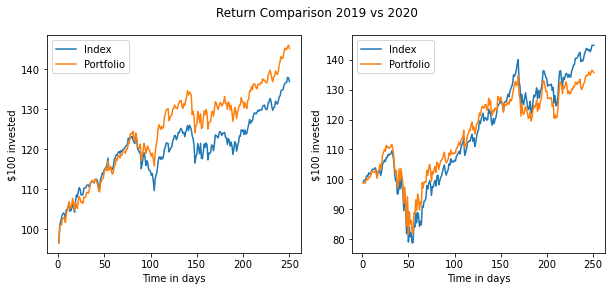

In sample error (Using 2019 Returns) 0.7891782824631473
Out of sample error (Using 2020 Returns) 1.1124373455076464


In [6]:
m = 5
errors_2019, errors_2020 = choose_stocks(5,b,A,sense,n,obj,True)
print('In sample error (Using 2019 Returns)', errors_2019)
print('Out of sample error (Using 2020 Returns)', errors_2020)

In [7]:
errors_2019,errors_2020 = [],[]
for m in range(10,101,10):
    error_2019, error_2020 =  choose_stocks(m,b,A,sense,n,obj,False)
    errors_2019.append(error_2019)
    errors_2020.append(error_2020)

<ipython-input-7-ce94c1f5c52b>:3: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  error_2019, error_2020 =  choose_stocks(m,b,A,sense,n,obj,False)
<ipython-input-5-0fc8ea28d5a3>:22: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  weights, error_2019 = find_w(returns[stocks])


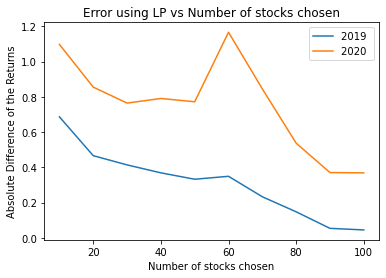

In [16]:
plt.plot([i for i in range(10,101,10)],errors_2019)
plt.plot([i for i in range(10,101,10)],errors_2020)
plt.xlabel('Number of stocks chosen')
plt.ylabel('Absolute Difference of the Returns')
plt.legend(['2019 ','2020 '])
plt.title('Error using LP vs Number of stocks chosen')
plt.show()

# Question 4

In [9]:
# Method 2, Directly Calculating the Weights choosing the Number of Stocks.

df = pd.read_csv('stocks2019.csv')
df.set_index('X',inplace = True)

df2 = pd.read_csv('stocks2020.csv')

df2.set_index('Unnamed: 0',inplace = True)

index_return_2019 = df[['NDX']].pct_change().dropna()
stock_returns_2019 = df.drop(['NDX'],axis = 1).pct_change().dropna()
stock_return_corr = stock_returns_2019.corr()

index_return_2020 = df2[['NDX']].pct_change().dropna()
stock_returns_2020 = df2.drop(['NDX'],axis = 1).pct_change().dropna()

def weights_of_stocks(numberofstocks, timelimit):

    # total time_periods
    t = len(index_return_2019)

    n = 100 # total stocks 
    M = numberofstocks
    b=[]
    
    if numberofstocks > 100:
        return print('Number of Stocks should be <= 100')

    A = np.zeros((2*t+1+ n+1,n+t+ n))
    
    # Stocks in Portfolio
    
    A[0,:n] = 1
    b.append(1)
    
    
    # The difference of return is a modulus
    
    # Constrain for opening Modulus
    # Postive
    for i in range(t):
        A[i+1,i+n]=1
        b.append(index_return_2019.iloc[i,0])

        for j in range(n):
            A[i+1,j] = stock_returns_2019.iloc[i,j]


    # Negative
    for i in range(t):
        A[i+1+t,i+n]=1
        b.append(index_return_2019.iloc[i,0]*-1)

        for j in range(n):
            A[i+1+t,j] = stock_returns_2019.iloc[i,j]*-1


    
    # Slack Variables for difference in returns portfolio vs index
    
    A[2*t+1,n+t:] = 1        
    b.append(M)

    for i in range(n):
        A[2*t+1+1+i,i] = -1
        A[2*t+1+1+i,n+t+i] = 1
        b.append(0)


    sense = ['='] + ['>']*2*t + ['='] + ['>']*n
    b = np.array(b)

    # Minimising Slack variables.
    
    obj = np.array([0]*n+[1]*t + [0]*n)
    
    # variable_type Binary Stock and Continous slack.
    variable_type = ['C']*(n+t) + ['B']*n


    ipMod = gp.Model()
    # Giving Timer for each run @ 60 mins.
    ipMod.setParam('TimeLimit', timelimit)
    ipMod_x = ipMod.addMVar(len(obj),vtype=variable_type) # 'C' or 'I' or 'B'
    ipMod_con = ipMod.addMConstrs(A, ipMod_x, sense, b)
    ipMod.setMObjective(None,obj,0,sense=gp.GRB.MINIMIZE)

    ipMod.Params.OutputFlag = 0 # tell gurobi to shut up!!
    ipMod.optimize()
    
    return ipMod_x.x[:100]

The following block will take forever to run, the results are saved in the weights_of_portfolio.csv file

In [11]:
# Loading Weights for each number of stocks
weights_mip = pd.read_csv('weights_of_portfolio.csv')
weights_mip.drop('Unnamed: 0',axis=1,inplace=True)
# Index of the DataFrame is the number of stocks in the Portfolio and Columns is the stock weights.

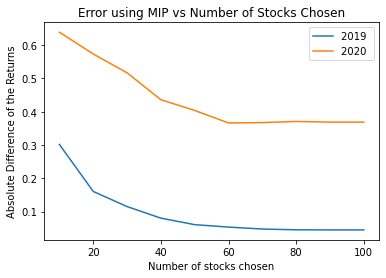

In [15]:
errors_2019_mip = []
errors_2020_mip = []
for i in range(0,10):
    mip_2019 = stock_returns_2019.mul(weights_mip.iloc[i,:],axis=1).sum(axis=1)
    mip_2020 = stock_returns_2020.mul(weights_mip.iloc[i,:],axis=1).sum(axis=1)
    errors_2019_mip.append(sum(abs(mip_2019 - index_return_2019['NDX']).values))
    errors_2020_mip.append(sum(abs(mip_2020 - index_return_2020['NDX']).values))

plt.plot([i for i in range(10,101,10)],errors_2019_mip)
plt.plot([i for i in range(10,101,10)],errors_2020_mip)
plt.xlabel('Number of stocks chosen')
plt.ylabel('Absolute Difference of the Returns')
plt.legend(['2019 ','2020 '])
plt.title('Error using MIP vs Number of Stocks Chosen')
plt.show()

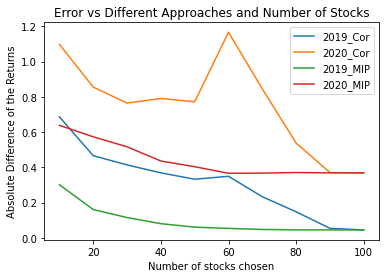

In [14]:
plt.plot([i for i in range(10,101,10)],errors_2019)
plt.plot([i for i in range(10,101,10)],errors_2020)
plt.plot([i for i in range(10,101,10)],errors_2019_mip)
plt.plot([i for i in range(10,101,10)],errors_2020_mip)

plt.xlabel('Number of stocks chosen')
plt.ylabel('Absolute Difference of the Returns')
plt.legend(['2019_Cor','2020_Cor','2019_MIP','2020_MIP'])
plt.title('Error vs Different Approaches and Number of Stocks')
plt.show()